# HW1: Handwritten Digit Recognition via Clustering Algorithm

Running K-Medoids on clean data...
Running K-Means on clean data...
(5, 784)


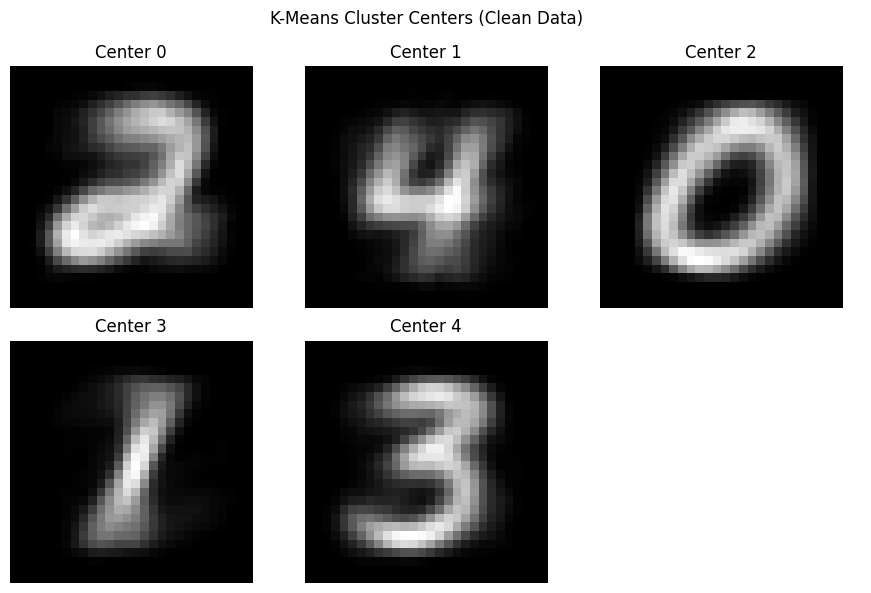

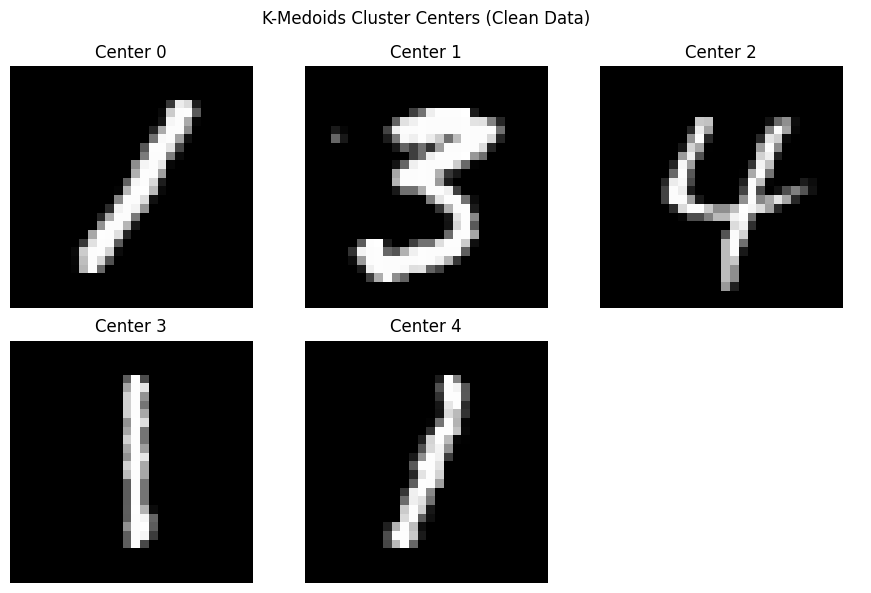

K-Medoids accuracy (clean data): 0.5170
K-Means accuracy (clean data): 0.8490
Adding contaminanted datapoints to the data...
Running K-Medoids on contaminated data...
Running K-Means on contaminated data...
K-Medoids accuracy (contaminated data): 0.6560
K-Means accuracy (contaminated data): 0.7290


In [30]:
import numpy as np
from utils import plot_cluster_centers, load_images_labels
from skimage.metrics import structural_similarity as ssim

def ssim_score(img1, img2):

    # Determine data range based on image type
    #data_range = img1.max() - img1.min() if img1.dtype == np.float32 or img1.dtype == np.float64 else 255

    # Compute SSIM
    return ssim(img1, img2, data_range=255)


def compute_dist(X, centers):
    """
    Compute the Euclidean distance between each point in X and each center in 'centers'.
    X: N x D
    centers: K x D
    Output: N x K matrix of distances
    """
    N, D = X.shape
    K = centers.shape[0]
    dist = np.sqrt(np.sum((X[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2))
    return dist

def mykmeans(digits, K):
    """
    Perform K-means clustering on 'digits' using K clusters.

    digits: (N, D) - N data points, each of dimension D = 784
    K: number of clusters
    max_iter: maximum number of iterations

    Returns:
      - cluster_assignments: (N,) array of cluster indices [0..K-1]
      - centers: (K, D) array of cluster centers
    """
    N,D = digits.shape
    #randomly pick centers to begin with
    centers = np.random.randint(low=0, high=100, size=(K, D))
    #initial the cluster assignment for each data point
    cluster_assignments = np.zeros(N)

    max_iter = 500
    for i in range(max_iter):
      #compute the distance.
      distance  = compute_dist(digits, centers)

      #update the assignment of each data point accrording to the dist we just computed
      cluster_assignments = np.argmin(distance, axis=1)

      #update the centers
      new_centers = []
      for j in range(K):
        count = 0 #keep track of how many data points is in cluster C_j
        new_center = np.zeros(D)
        for l in range(N):
          if cluster_assignments[l] == j:    #if x_l has assignment j i.e. x_l is in cluster C_j
            count +=1
            new_center += digits[l,:]
        new_center /= count
        new_centers.append(new_center)

      # Check whether the centers changed or not
      if np.array_equal(centers, new_centers):
        break

      centers = np.array(new_centers)
    return cluster_assignments, centers




def mykmedoids(digits, K):
    """
    Perform K-medoids clustering on 'digits' using K clusters.

    digits: (N, D) - N data points, each of dimension D = 784
    K: number of clusters
    max_iter: maximum number of iterations

    Returns:
      - cluster_assignments: (N,) array of cluster indices [0..K-1]
      - centers: (K, D) array of medoids (a subset of the original points)
    """
    N,D = digits.shape
    # Randomly select k data points as the initial medoids
    medoids = digits[np.random.choice(digits.shape[0], K, replace=False)]
    max_iter = 500

    for i in range(max_iter):
      # try a new way to store to cluster assignment information using dictionary.
      clusters = {i: [] for i in range(K)}

      # Assign each point to the nearest medoid
      for index, point in enumerate(digits):
        distances = [np.linalg.norm(point - medoid) for medoid in medoids] #compute the distance of the point to every center
        closest_medoid = np.argmin(distances)  #return the index of the closest medoid
        clusters[closest_medoid].append(index)  # Assign point to the closest medoid

      #update new center, which is the data point with minimum distance to all other data points.
      new_medoids = []
      for cluster in clusters.values():
        # Calculate the medoid for the given cluster
        #(the point with the smallest sum of distances to all other points in the cluster)
        best_medoid = None
        min_total_dis = float('inf')

        for i in cluster:

          #L2 norm
          total_dis= sum(np.linalg.norm(digits[i]-digits[j]) for j in cluster)

          #SSIM distance
          #we should put negative sign in front of the ssim distance,
          #since the larger SSIM is the more similar two images are
          #total_dis= sum(-ssim_score(digits[i],digits[j]) for j in cluster)

          if total_dis < min_total_dis:
            min_total_dis = total_dis
            best_medoid = digits[i]
        new_medoids.append(best_medoid)

      # Check whether the medoids changed or not
      if np.array_equal(medoids, new_medoids):
        break

      medoids = np.array(new_medoids)


    # extract assignment information from dictionary cluster into a list
    ls = [1]* N
    # For each cluster (medoid index and its associated points)
    for cluster_index, points in clusters.items():
        # Assign the cluster_id to each point in the cluster
        for point_index in points:
            ls[point_index] = cluster_index
    cluster_assignments = np.array(ls)

    return cluster_assignments, medoids


def evaluate_clustering(cluster_assignments, labels, K):
    """
    Evaluate the clustering result by assigning each cluster to the most frequent
    true label in that cluster, then compute the overall accuracy.

    cluster_assignments: (N,) array of cluster indices
    labels: (N,) array of true digit labels
    K: number of clusters
    Returns:
      accuracy (float)
    """
    correct = 0
    N = len(labels)

    for k in range(K):
        cluster_points_idx = np.where(cluster_assignments == k)[0]
        if len(cluster_points_idx) == 0:
            continue
        cluster_labels = labels[cluster_points_idx]
        most_common_label = np.bincount(cluster_labels).argmax()
        correct += np.sum(cluster_labels == most_common_label)

    accuracy = correct / N
    return accuracy


def main():
    # Load the data
    directory = "data"
    images, labels = load_images_labels(directory)

    # In case you get an out of memory error you may decrease N
    N = 1000
    images_subset = images[:N].astype(np.float32)
    labels_subset = labels[:N]

    K = 5  # Number of clusters

    # Apply K-Medoids on the clean data
    print("Running K-Medoids on clean data...")
    kmedoids_assignments, kmedoids_centers = mykmedoids(images_subset, K)

    # Apply K-Means on the clean data
    print("Running K-Means on clean data...")
    kmeans_assignments, kmeans_centers = mykmeans(images_subset, K)
    print(kmeans_centers.shape)

    # Plot cluster centers
    plot_cluster_centers(kmeans_centers, "K-Means Cluster Centers (Clean Data)", K)
    plot_cluster_centers(kmedoids_centers, "K-Medoids Cluster Centers (Clean Data)", K)

    # Evaluate clustering accuracy
    kmedoids_accuracy = evaluate_clustering(kmedoids_assignments, labels_subset, K)
    print(f"K-Medoids accuracy (clean data): {kmedoids_accuracy:.4f}")
    kmeans_accuracy = evaluate_clustering(kmeans_assignments, labels_subset, K)
    print(f"K-Means accuracy (clean data): {kmeans_accuracy:.4f}")

    # Add noisy contaminanted datapoints/outliers to the dataset
    print("Adding contaminanted datapoints to the data...")
    num_outliers = 100
    image_size = images_subset.shape[1]
    outliers = np.random.randint(0, 256, size=(num_outliers, image_size)).astype(np.float32)
    images_contaminated = np.vstack([images_subset, outliers])
    labels_contaminated = np.hstack([labels_subset, -1 * np.ones(num_outliers, dtype=int)])
    print("Running K-Medoids on contaminated data...")
    kmedoids_assignments_cont, kmedoids_centers_cont = mykmedoids(images_contaminated, K)
    print("Running K-Means on contaminated data...")
    kmeans_assignments_cont, kmeans_centers_cont = mykmeans(images_contaminated, K)

    # Evaluate clustering accuracy after contamination
    mask_no_outliers = labels_contaminated != -1
    kmedoids_accuracy_cont = evaluate_clustering(kmedoids_assignments_cont[mask_no_outliers], labels_contaminated[mask_no_outliers], K)
    print(f"K-Medoids accuracy (contaminated data): {kmedoids_accuracy_cont:.4f}")
    kmeans_accuracy_cont = evaluate_clustering(kmeans_assignments_cont[mask_no_outliers], labels_contaminated[mask_no_outliers], K)
    print(f"K-Means accuracy (contaminated data): {kmeans_accuracy_cont:.4f}")

if __name__ == "__main__":
    main()